In [1]:
import numpy as np


In [10]:
d_in = np.load('/home/siavash/random/dsseg/output/d_in.npy').squeeze(0)
d_out = np.load('/home/siavash/random/dsseg/output/d_out.npy').squeeze(0)
d_in.shape, d_out.shape

((4, 64, 8640), (1, 64, 8640))

In [14]:
#convert numpy array to image
from PIL import Image
im = Image.fromarray(d_in[0])
im.save("/home/siavash/random/dsseg/output/d_in.png")


TypeError: Cannot handle this data type: (1, 1), <f2

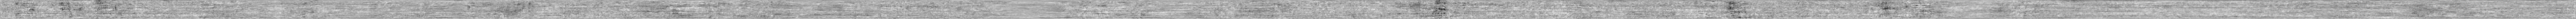

In [34]:
d_in.max(), d_in.min(), d_out.max(), d_out.min()
#convert numpy array to image
normalized_data = (d_out - np.min(d_out)) / (np.max(d_out) - np.min(d_out)) * 255
normalized_data = normalized_data.astype(np.uint8)

# Create an image from the NumPy array
image = Image.fromarray(normalized_data[0])
image.save('/home/siavash/random/dsseg/output/d_out.png')
image


In [21]:
normalized_data[0].shape

(64, 8640)

In [6]:
from typing import Callable, Optional

import torch
import torch.nn as nn


# ref: https://github.com/analokmaus/kaggle-g2net-public/tree/main/models1d_pytorch
class CNNSpectrogram(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        base_filters: int | tuple = 128,
        kernel_sizes: tuple = (32, 16, 8, 4, 2),
        stride: int = 4,
        sigmoid: bool = False,
        output_size: Optional[int] = None,
        conv: Callable = nn.Conv1d,
        reinit: bool = True,
    ):
        super().__init__()
        self.out_chans = len(kernel_sizes)
        self.out_size = output_size
        self.sigmoid = sigmoid
        if isinstance(base_filters, int):
            base_filters = tuple([base_filters])
        self.height = base_filters[-1]
        self.spec_conv = nn.ModuleList()
        for i in range(self.out_chans):
            tmp_block = [
                conv(
                    in_channels,
                    base_filters[0],
                    kernel_size=kernel_sizes[i],
                    stride=stride,
                    padding=(kernel_sizes[i] - 1) // 2,
                )
            ]
            if len(base_filters) > 1:
                for j in range(len(base_filters) - 1):
                    tmp_block = tmp_block + [
                        nn.BatchNorm1d(base_filters[j]),
                        nn.ReLU(inplace=True),
                        conv(
                            base_filters[j],
                            base_filters[j + 1],
                            kernel_size=kernel_sizes[i],
                            stride=stride,
                            padding=(kernel_sizes[i] - 1) // 2,
                        ),
                    ]
                self.spec_conv.append(nn.Sequential(*tmp_block))
            else:
                self.spec_conv.append(tmp_block[0])

        if self.out_size is not None:
            self.pool = nn.AdaptiveAvgPool2d((None, self.out_size))

        if reinit:
            for m in self.modules():
                if isinstance(m, nn.Conv1d):
                    nn.init.kaiming_normal_(m.weight)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the model.

        Args:
            x (_type_): (batch_size, in_channels, time_steps)

        Returns:
            _type_: (batch_size, out_chans, height, time_steps)
        """
        # x: (batch_size, in_channels, time_steps)
        out: list[torch.Tensor] = []
        print(f"input shape: {x.shape}")
        for i in range(self.out_chans):
            out.append(self.spec_conv[i](x))
        img = torch.stack(out, dim=1)  # (batch_size, out_chans, height, time_steps)
        if self.out_size is not None:
            img = self.pool(img)  # (batch_size, out_chans, height, out_size)
        if self.sigmoid:
            img = img.sigmoid()
        print(f"output shape: {img.shape}")
        return img


In [7]:
model = CNNSpectrogram(6, 64, (32, 16, 2), 2, sigmoid=True, output_size=4320, conv=nn.Conv1d, reinit=True)

In [8]:
model.cuda()

CNNSpectrogram(
  (spec_conv): ModuleList(
    (0): Conv1d(6, 64, kernel_size=(32,), stride=(2,), padding=(15,))
    (1): Conv1d(6, 64, kernel_size=(16,), stride=(2,), padding=(7,))
    (2): Conv1d(6, 64, kernel_size=(2,), stride=(2,))
  )
  (pool): AdaptiveAvgPool2d(output_size=(None, 4320))
)

In [11]:
inp = torch.randn(1, 6, 8640).cuda()
_ = model(inp)

input shape: torch.Size([1, 6, 8640])
output shape: torch.Size([1, 3, 64, 4320])


In [13]:
from collections.abc import Callable

import torch
import torch.nn as nn
import torch.nn.functional as F


class MyConv1dPadSame(nn.Module):
    """
    extend nn.Conv1d to support SAME padding
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups=1):
        super(MyConv1dPadSame, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.conv = torch.nn.Conv1d(
            in_channels=self.in_channels, 
            out_channels=self.out_channels, 
            kernel_size=self.kernel_size, 
            stride=self.stride, 
            groups=self.groups)

    def forward(self, x):
        
        net = x
        
        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)
        
        net = self.conv(net)

        return net

      
class MyMaxPool1dPadSame(nn.Module):
    """
    extend nn.MaxPool1d to support SAME padding
    """
    def __init__(self, kernel_size):
        super(MyMaxPool1dPadSame, self).__init__()
        self.kernel_size = kernel_size
        self.stride = 1
        self.max_pool = torch.nn.MaxPool1d(kernel_size=self.kernel_size)

    def forward(self, x):
        
        net = x
        
        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)
        
        net = self.max_pool(net)
        
        return net


class BasicBlock(nn.Module):
    """
    ResNet Basic Block
    """
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size, 
                 stride, 
                 groups, 
                 downsample, 
                 use_bn, 
                 dropout=0.2, 
                 activation=nn.ReLU,
                 is_first_block=False):
        super(BasicBlock, self).__init__()
        
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.out_channels = out_channels
        self.stride = stride
        self.groups = groups
        self.downsample = downsample
        if self.downsample:
            self.stride = stride
        else:
            self.stride = 1
        self.is_first_block = is_first_block
        self.use_bn = use_bn
        self.dropout = dropout
        self.activation = activation

        # the first conv
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = self.activation(inplace=True)
        self.do1 = nn.Dropout(p=self.dropout)
        self.conv1 = MyConv1dPadSame(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=self.stride,
            groups=self.groups)

        # the second conv
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = self.activation(inplace=True)
        self.do2 = nn.Dropout(p=self.dropout)
        self.conv2 = MyConv1dPadSame(
            in_channels=out_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=1,
            groups=self.groups)
                
        self.max_pool = MyMaxPool1dPadSame(kernel_size=self.stride)

    def forward(self, x):
        
        identity = x
        
        # the first conv
        out = x
        if not self.is_first_block:
            if self.use_bn:
                out = self.bn1(out)
            out = self.relu1(out)
            out = self.do1(out)
        out = self.conv1(out)
        
        # the second conv
        if self.use_bn:
            out = self.bn2(out)
        out = self.relu2(out)
        out = self.do2(out)
        out = self.conv2(out)
        
        # if downsample, also downsample identity
        if self.downsample:
            identity = self.max_pool(identity)
            
        # if expand channel, also pad zeros to identity
        if self.out_channels != self.in_channels:
            identity = identity.transpose(-1,-2)
            ch1 = (self.out_channels-self.in_channels)//2
            ch2 = self.out_channels-self.in_channels-ch1
            identity = F.pad(identity, (ch1, ch2), "constant", 0)
            identity = identity.transpose(-1,-2)
        
        # shortcut
        out += identity

        return out


class ResNet1d(nn.Module):
    """
    
    Input:
        X: (n_samples, n_channel, n_length)
        Y: (n_samples)
        
    Output:
        out: (n_samples)
        
    Pararmetes:
        in_channels: dim of input, the same as n_channel
        base_filters: number of filters in the first several Conv layer, it will double at every 4 layers
        kernel_size: width of kernel
        stride: stride of kernel moving
        groups: set larget to 1 as ResNeXt
        n_block: number of blocks
        n_classes: number of classes
        
    """

    def __init__(self, 
                 in_channels, 
                 base_filters, 
                 kernel_size, 
                 stride=2, 
                 groups=32, 
                 n_block=16, 
                 n_classes=1, 
                 downsample_gap=None, 
                 increasefilter_gap=None, 
                 use_bn=True, 
                 dropout=0.2, 
                 activation=nn.ReLU,
                 final_act=True,
                 reinit=False):
        super(ResNet1D, self).__init__()
        
        self.n_block = n_block
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.use_bn = use_bn
        self.dropout = dropout
        self.activation = activation
        self.final_act = final_act

        if downsample_gap is None:
            downsample_gap = self.n_block // 8
        self.downsample_gap = downsample_gap # 2 for base model
        if increasefilter_gap is None:
            increasefilter_gap = self.n_block // 4
        self.increasefilter_gap = increasefilter_gap # 4 for base model

        # first block
        self.first_block_conv = MyConv1dPadSame(
            in_channels=in_channels, 
            out_channels=base_filters, 
            kernel_size=self.kernel_size, 
            stride=1)
        self.first_block_bn = nn.BatchNorm1d(base_filters)
        self.first_block_relu = self.activation(inplace=True)
        out_channels = base_filters
                
        # residual blocks
        self.basicblock_list = nn.ModuleList()
        for i_block in range(self.n_block):
            # is_first_block
            if i_block == 0:
                is_first_block = True
            else:
                is_first_block = False
            # downsample at every self.downsample_gap blocks
            if i_block % self.downsample_gap == 1:
                downsample = True
            else:
                downsample = False
            # in_channels and out_channels
            if is_first_block:
                in_channels = base_filters
                out_channels = in_channels
            else:
                # increase filters at every self.increasefilter_gap blocks
                in_channels = int(base_filters*2**((i_block-1)//self.increasefilter_gap))
                if (i_block % self.increasefilter_gap == 0) and (i_block != 0):
                    out_channels = in_channels * 2
                else:
                    out_channels = in_channels
            
            tmp_block = BasicBlock(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=self.kernel_size, 
                stride = self.stride, 
                groups = self.groups, 
                downsample=downsample, 
                use_bn = self.use_bn,  
                dropout = self.dropout, 
                activation = self.activation,
                is_first_block=is_first_block)
            self.basicblock_list.append(tmp_block)

        # final prediction
        self.final_bn = nn.BatchNorm1d(out_channels)
        self.final_relu = self.activation(inplace=True)
        self.final_pool = nn.AdaptiveAvgPool1d(1)
        self.dense = nn.Linear(out_channels, n_classes)

        # init 
        if reinit:
            for m in self.modules():
                if isinstance(m, nn.Conv1d):
                    nn.init.kaiming_normal_(m.weight)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        out = self.first_block_conv(x)
        if self.use_bn:
            out = self.first_block_bn(out)
        out = self.first_block_relu(out)
        
        # residual blocks, every block has two conv
        for i_block in range(self.n_block):
            net = self.basicblock_list[i_block]
            out = net(out)
        
        # final prediction
        if self.final_act:
            if self.use_bn:
                out = self.final_bn(out)
            out = self.final_relu(out)

        # out = out.mean(-1)
        out = self.final_pool(out)
        return out

    def forward(self, x):
        out = self.forward_features(x)
        out = out.squeeze(-1)
        out = self.dense(out)
        return out    

    def reset_classifier(self, **kwargs):
        self.dense = nn.Identity()

    def get_classifier(self):
        return self.dense

ResNet1D = ResNet1d # alias

class CNN1d(nn.Module):
    '''
    '''
    def __init__(self,
                 in_channels: int = 3,
                 num_classes: int = 1, 
                 hidden_dims: tuple = (8, 16, 32, 64), 
                 kernel_size: int = 3,
                 reinit: bool = False):

        super().__init__()

        # first conv
        self.features= nn.Sequential(
            nn.Conv1d(in_channels=in_channels,
                      out_channels=hidden_dims[0],
                      kernel_size=kernel_size,
                      padding='same'),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.SiLU(inplace=True))
        
        for i in range(len(hidden_dims)-1):
            conv_layer = nn.Sequential(
                nn.Conv1d(in_channels=hidden_dims[i],
                          out_channels=hidden_dims[i+1],
                          kernel_size=kernel_size,
                          padding='same'),
                nn.BatchNorm1d(hidden_dims[i+1]),
                nn.SiLU(inplace=True)
            )
            self.features.add_module(f'block{i}', conv_layer)
        
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(hidden_dims[-1], num_classes))

        if reinit:
            for m in self.modules():
                if isinstance(m, nn.Conv1d):
                    nn.init.kaiming_normal_(m.weight)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        return self.features(x)

    def forward(self, x):
        features = self.forward_features(x)
        return self.head(features)


'''
WaveNet variants
'''
class WaveBlock(nn.Module):

    def __init__(self, num_layers, in_channels, num_filters, kernel_size, downsample=False):
        super().__init__()
        dilation_rates = [2**i for i in range(num_layers)]
        if downsample:
            if isinstance(downsample, bool):
                first_stride = 2
            else:
                first_stride = downsample
            first_kernel_size = first_stride + 1
            first_padding = (first_kernel_size-1)//2
            self.first_conv = nn.Conv1d(in_channels,
                                        num_filters,
                                        kernel_size=first_kernel_size,
                                        stride=first_stride,
                                        padding=first_padding)
        else:
            self.first_conv = nn.Conv1d(in_channels,
                                        num_filters,
                                        kernel_size=1,
                                        padding='same')
        self.tanh_conv = nn.ModuleList()
        self.sigm_conv = nn.ModuleList()
        self.final_conv = nn.ModuleList()
        for _, dilation_rate in enumerate(dilation_rates):
            self.tanh_conv.append(nn.Sequential(
                nn.Conv1d(num_filters,
                          num_filters,
                          kernel_size=kernel_size,
                          dilation=dilation_rate,
                          padding='same'),
                nn.Tanh(),
            ))
            self.sigm_conv.append(nn.Sequential(
                nn.Conv1d(num_filters,
                          num_filters,
                          kernel_size=kernel_size,
                          dilation=dilation_rate,
                          padding='same'),
                nn.Sigmoid(),
            ))
            self.final_conv.append(nn.Conv1d(num_filters,
                                             num_filters,
                                             kernel_size=1,
                                             padding='same'))
    
    def forward(self, x):
        x = self.first_conv(x)
        res_x = x
        for i in range(len(self.tanh_conv)):
            tanh_out = self.tanh_conv[i](x)
            sigm_out = self.sigm_conv[i](x)
            x = tanh_out * sigm_out
            x = self.final_conv[i](x)
            res_x = res_x + x
        
        return res_x


class SimplifiedWaveBlock(nn.Module):

    def __init__(self, num_layers, in_channels, num_filters, kernel_size, downsample=False):
        super().__init__()
        dilation_rates = [2**i for i in range(num_layers)]
        if downsample:
            if isinstance(downsample, bool):
                first_stride = 2
            else:
                first_stride = downsample
            first_kernel_size = first_stride + 1
            first_padding = (first_kernel_size-1)//2
            self.first_conv = nn.Conv1d(in_channels,
                                        num_filters,
                                        kernel_size=first_kernel_size,
                                        stride=first_stride,
                                        padding=first_padding)
        else:
            self.first_conv = nn.Conv1d(in_channels,
                                        num_filters,
                                        kernel_size=1,
                                        padding='same')
        self.conv_act = nn.ModuleList()
        for _, dilation_rate in enumerate(dilation_rates):
            self.conv_act.append(nn.Sequential(
                nn.BatchNorm1d(num_filters),
                nn.ReLU(inplace=True),
                nn.Conv1d(num_filters,
                          num_filters,
                          kernel_size=kernel_size,
                          dilation=dilation_rate,
                          padding='same'),
                nn.BatchNorm1d(num_filters),
                nn.ReLU(inplace=True),
                nn.Conv1d(num_filters,
                          num_filters,
                          kernel_size=1,
                          padding='same'),
            ))
    
    def forward(self, x):
        x = self.first_conv(x)
        res_x = x
        for i in range(len(self.conv_act)):
            x = self.conv_act[i](x)
            res_x = res_x + x
        return res_x
        

class WaveNet1d(nn.Module):

    def __init__(self,
                 in_channels: int = 3,
                 hidden_dims: tuple = (16, 32, 64, 128), 
                 wave_layers: tuple = (12, 8, 4, 1),
                 wave_block: str = 'none',
                 kernel_size: int = 3,
                 num_classes: int = 1,
                 activation: nn.Module = nn.ReLU, 
                 downsample: bool | tuple = False,
                 reinit: bool = False):

        super().__init__()

        if wave_block == 'simplified':
            wave_block = SimplifiedWaveBlock
        else:
            wave_block = WaveBlock

        assert len(hidden_dims) == len(wave_layers)
        num_blocks = len(hidden_dims)
        if not isinstance(downsample, bool):
            assert len(downsample) == len(hidden_dims)
        else:
            downsample = tuple([downsample for _ in range(num_blocks)])

        self.features = nn.Sequential()
        self.features.add_module(
            'waveblock0', wave_block(
                wave_layers[0], 
                in_channels, 
                hidden_dims[0], 
                kernel_size,
                downsample[0]))
        self.features.add_module(
            'bn0', nn.BatchNorm1d(hidden_dims[0]))
        for i in range(num_blocks-1):
            self.features.add_module(
                f'waveblock{i+1}', wave_block(
                    wave_layers[i+1], 
                    hidden_dims[i], 
                    hidden_dims[i+1], 
                    kernel_size,
                    downsample[i+1]))
            self.features.add_module(
                f'bn{i+1}', nn.BatchNorm1d(hidden_dims[i+1]))
        self.final_pool = nn.AdaptiveAvgPool1d(1)
        self.final_act = activation(inplace=True)
        self.classifier = nn.Linear(hidden_dims[-1], num_classes)

        if reinit:
            for m in self.modules():
                if isinstance(m, nn.Conv1d):
                    nn.init.kaiming_normal_(m.weight)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        x = self.features(x)
        return self.final_pool(self.final_act(x))
    
    def forward(self, x):
        features = self.forward_features(x)
        features = features.squeeze(-1)
        return self.classifier(features)

    def reset_classifier(self):
        self.classifier = nn.Identity()

    def get_classifier(self):
        return self.classifier


class WaveNetSpectrogram(nn.Module):

    def __init__(self,
                 in_channels: int = 3,
                 base_filters: int | tuple = 128,
                 wave_layers: tuple = (10, 6, 2),
                 wave_block: str = 'simplified',
                 kernel_size: int = 3, 
                 downsample: int = 4,
                 sigmoid: bool = False, 
                 output_size: int = None, 
                 separate_channel: bool = False,
                 reinit: bool = True):

        super().__init__()

        if wave_block == 'simplified':
            wave_block = SimplifiedWaveBlock
        else:
            wave_block = WaveBlock

        self.out_chans = len(wave_layers)
        self.out_size = output_size
        self.sigmoid = sigmoid
        self.separate_channel = separate_channel
        if isinstance(base_filters, int):
            base_filters = tuple([base_filters])

        self.spec_conv = nn.ModuleList()
        for i in range(self.out_chans):
            tmp_blocks = [wave_block(
                wave_layers[i], 
                in_channels, 
                base_filters[0], 
                kernel_size,
                downsample)]
            if len(base_filters) > 1:
                for j in range(len(base_filters) - 1):
                    tmp_blocks = tmp_blocks + [
                        wave_block(
                            wave_layers[i], 
                            base_filters[j], 
                            base_filters[j+1], 
                            kernel_size,
                            downsample)
                    ]
                self.spec_conv.append(nn.Sequential(*tmp_blocks))
            else:
                self.spec_conv.append(tmp_blocks[0])
        
        if self.out_size is not None:
            self.pool = nn.AdaptiveAvgPool2d((None, self.out_size))
        
        if reinit:
            for m in self.modules():
                if isinstance(m, nn.Conv1d):
                    nn.init.kaiming_normal_(m.weight)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.constant_(m.bias, 0)

    def forward(self, x): # x: (bs, ch, w)
        out = []
        if not self.separate_channel:
            for i in range(self.out_chans):
                out.append(self.spec_conv[i](x))
        else:
            for i in range(self.out_chans):
                out.append(self.spec_conv[i](x[:, i, :].unsqueeze(1)))
        out = torch.stack(out, dim=1)
        if self.out_size is not None:
            out = self.pool(out)
        if self.sigmoid:
            out = out.sigmoid()
        return out


class CNNSpectrogram(nn.Module):

    def __init__(self,
                 in_channels: int = 3,
                 base_filters: int | tuple = 128, 
                 kernel_sizes: tuple = (32, 16, 4), 
                 stride: int = 4, 
                 sigmoid: bool = False, 
                 output_size: int = None,
                 conv: Callable = nn.Conv1d, 
                 disable_amp: bool = False, 
                 reinit: bool = True):

        super().__init__()

        self.out_chans = len(kernel_sizes)
        self.out_size = output_size
        self.sigmoid = sigmoid
        self.disable_amp = disable_amp
        if isinstance(base_filters, int):
            base_filters = tuple([base_filters])
        
        self.spec_conv = nn.ModuleList()
        for i in range(self.out_chans):
            tmp_block = [
                conv(
                   in_channels, 
                   base_filters[0],
                   kernel_size=kernel_sizes[i],
                   stride=stride,
                   padding=(kernel_sizes[i]-1)//2,)]
            if len(base_filters) > 1:
                for j in range(len(base_filters)-1):
                    tmp_block = tmp_block + [
                        nn.BatchNorm1d(base_filters[j]),
                        nn.ReLU(inplace=True),
                        conv(
                            base_filters[j], 
                            base_filters[j+1],
                            kernel_size=kernel_sizes[i],
                            stride=stride,
                            padding=(kernel_sizes[i]-1)//2,)
                    ]
                self.spec_conv.append(nn.Sequential(*tmp_block))
            else:
                self.spec_conv.append(tmp_block[0])
        
        if self.out_size is not None:
            self.pool = nn.AdaptiveAvgPool2d((None, self.out_size))
        
        if reinit:
            for m in self.modules():
                if isinstance(m, nn.Conv1d):
                    nn.init.kaiming_normal_(m.weight)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = []
        if self.disable_amp: 
            with torch.cuda.amp.autocast(enabled=False):
                for i in range(self.out_chans):
                    out.append(self.spec_conv[i](x))
        else:
            for i in range(self.out_chans):
                out.append(self.spec_conv[i](x))
        out = torch.stack(out, dim=1)
        if self.out_size is not None:
            out = self.pool(out)
        if self.sigmoid:
            out = out.sigmoid()
        return out


class ResNetSpectrogram(nn.Module):

    def __init__(self, 
                 in_channels: int = 3, 
                 base_filters: int = 32, 
                 kernel_size: int = 3, 
                 stride: int = 2, 
                 groups: int = 32, 
                 n_block: int = 16,
                 downsample_gap: int = 8,
                 increasefilter_gap: int = 6,
                 transpose: bool = False,
                 reinit: bool = False):
        super().__init__()
        
        self.n_block = n_block
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.activation = nn.ReLU
        self.downsample_gap = downsample_gap
        self.increasefilter_gap = increasefilter_gap
        self.transpose = transpose

        # first block
        self.first_block_conv = MyConv1dPadSame(
            in_channels=in_channels, 
            out_channels=base_filters, 
            kernel_size=self.kernel_size, 
            stride=1)
        self.first_block_bn = nn.BatchNorm1d(base_filters)
        self.first_block_relu = self.activation(inplace=True)
        out_channels = base_filters
                
        # residual blocks
        self.basicblock_list = nn.ModuleList()
        for i_block in range(self.n_block):
            # is_first_block
            if i_block == 0:
                is_first_block = True
            else:
                is_first_block = False
            # downsample at every self.downsample_gap blocks
            if i_block % self.downsample_gap == 1:
                downsample = True
            else:
                downsample = False
            # in_channels and out_channels
            if is_first_block:
                in_channels = base_filters
                out_channels = in_channels
            else:
                # increase filters at every self.increasefilter_gap blocks
                in_channels = int(base_filters*2**((i_block-1)//self.increasefilter_gap))
                if (i_block % self.increasefilter_gap == 0) and (i_block != 0):
                    out_channels = in_channels * 2
                else:
                    out_channels = in_channels
            
            tmp_block = BasicBlock(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=self.kernel_size, 
                stride=self.stride, 
                groups=self.groups, 
                downsample=downsample, 
                use_bn=True,  
                dropout=0.0, 
                activation=self.activation,
                is_first_block=is_first_block)
            self.basicblock_list.append(tmp_block)

        # init 
        if reinit:
            for m in self.modules():
                if isinstance(m, nn.Conv1d):
                    nn.init.kaiming_normal_(m.weight)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        
        out = self.first_block_conv(x)
        out = self.first_block_bn(out)
        out = self.first_block_relu(out)
        
        for i_block in range(self.n_block):
            out = self.basicblock_list[i_block](out)
        
        out = out.unsqueeze(1)

        if self.transpose:
            out = out.transpose(2, 3)
        return out

In [18]:
model = WaveNetSpectrogram(6, 64, (10, 6, 2), kernel_size=3, downsample=2, sigmoid=True, output_size=4320, reinit=True)

In [19]:
inp = torch.randn(1, 6, 8640).cuda()
model.cuda()
_ = model(inp)

In [22]:
model(torch.randn(64, 6, 8640).cuda()).shape

torch.Size([64, 3, 64, 4320])

In [10]:
import pandas as pd
import torch
from pathlib import Path
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from src.utils.metrics import event_detection_ap

from src.utils.post_process import post_process_for_seg
import jupyter_black
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import optuna


jupyter_black.load()
plt.style.use("ggplot")

EXP_NAME = "exp001"
RUN_NAME = "single"
RESULT_DIR = Path("../output/train") / EXP_NAME / RUN_NAME


def load_config(result_dir: Path):
    # clear previous initialization
    GlobalHydra.instance().clear()

    # initialize hydra
    config_path = result_dir / ".hydra"
    initialize(config_path=config_path.as_posix())
    # load the config
    cfg = compose(config_name="config")

    return cfg

In [11]:
cfg = load_config(RESULT_DIR)
preds = np.load(RESULT_DIR / "preds.npy")
labels = np.load(RESULT_DIR / "labels.npy")
keys = np.load(RESULT_DIR / "keys.npy")

gt_df = pd.read_csv(Path(cfg.dir.data_dir) / "train_events.csv")
gt_df = gt_df[gt_df["series_id"].isin(cfg.split.valid_series_ids)].dropna().reset_index(drop=True)

/tmp/ipykernel_3564882/2838256247.py:32: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path=config_path.as_posix())


In [13]:
def objective(trial: optuna.Trial):
    score_th = 0.005
    distance = trial.suggest_int("distance", 1, 200)

    pred_df: pl.DataFrame = post_process_for_seg(
        keys, preds[:, :, [1, 2]], score_th=score_th, distance=distance
    )
    score = event_detection_ap(gt_df, pred_df.to_pandas())

    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(study.best_params)

[I 2023-11-04 16:14:24,545] A new study created in memory with name: no-name-e10df946-a12a-48da-8de1-f59dab00225c
[I 2023-11-04 16:14:26,450] Trial 0 finished with value: 0.7370906735371032 and parameters: {'distance': 170}. Best is trial 0 with value: 0.7370906735371032.
[I 2023-11-04 16:14:28,577] Trial 1 finished with value: 0.7407685696377717 and parameters: {'distance': 70}. Best is trial 1 with value: 0.7407685696377717.
[I 2023-11-04 16:14:30,591] Trial 2 finished with value: 0.7411792079904059 and parameters: {'distance': 102}. Best is trial 2 with value: 0.7411792079904059.
[I 2023-11-04 16:14:32,521] Trial 3 finished with value: 0.7412631154260926 and parameters: {'distance': 86}. Best is trial 3 with value: 0.7412631154260926.
[I 2023-11-04 16:14:34,528] Trial 4 finished with value: 0.741279827761057 and parameters: {'distance': 104}. Best is trial 4 with value: 0.741279827761057.
[I 2023-11-04 16:14:36,468] Trial 5 finished with value: 0.7407235229843712 and parameters: {'d

{'distance': 96}


In [14]:
def plot_random_sample(keys, preds, labels, num_samples=1, num_chunks=10):
    # get series ids
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    unique_series_ids = np.unique(series_ids)

    # get random series
    random_series_ids = np.random.choice(unique_series_ids, num_samples)

    for i, random_series_id in enumerate(random_series_ids):
        # get random series
        series_idx = np.where(series_ids == random_series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 3)
        this_series_labels = labels[series_idx].reshape(-1, 3)

        # split series
        this_series_preds = np.split(this_series_preds, num_chunks)
        this_series_labels = np.split(this_series_labels, num_chunks)

        fig, axs = plt.subplots(num_chunks, 1, figsize=(20, 5 * num_chunks))
        if num_chunks == 1:
            axs = [axs]
        for j in range(num_chunks):
            this_series_preds_chunk = this_series_preds[j]
            this_series_labels_chunk = this_series_labels[j]

            # get onset and wakeup idx
            onset_idx = np.nonzero(this_series_labels_chunk[:, 1])[0]
            wakeup_idx = np.nonzero(this_series_labels_chunk[:, 2])[0]

            axs[j].plot(this_series_preds_chunk[:, 0], label="pred_sleep")
            axs[j].plot(this_series_preds_chunk[:, 1], label="pred_onset")
            axs[j].plot(this_series_preds_chunk[:, 2], label="pred_wakeup")
            # axs[j].vlines(onset_idx, 0, 1, label="onset", linestyles="dashed", color="C1")
            # axs[j].vlines(wakeup_idx, 0, 1, label="wakeup", linestyles="dashed", color="C2")
            axs[j].set_ylim(0, 1)
            axs[j].set_title(f"series_id: {random_series_id} chunk_id: {j}")
            axs[j].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()

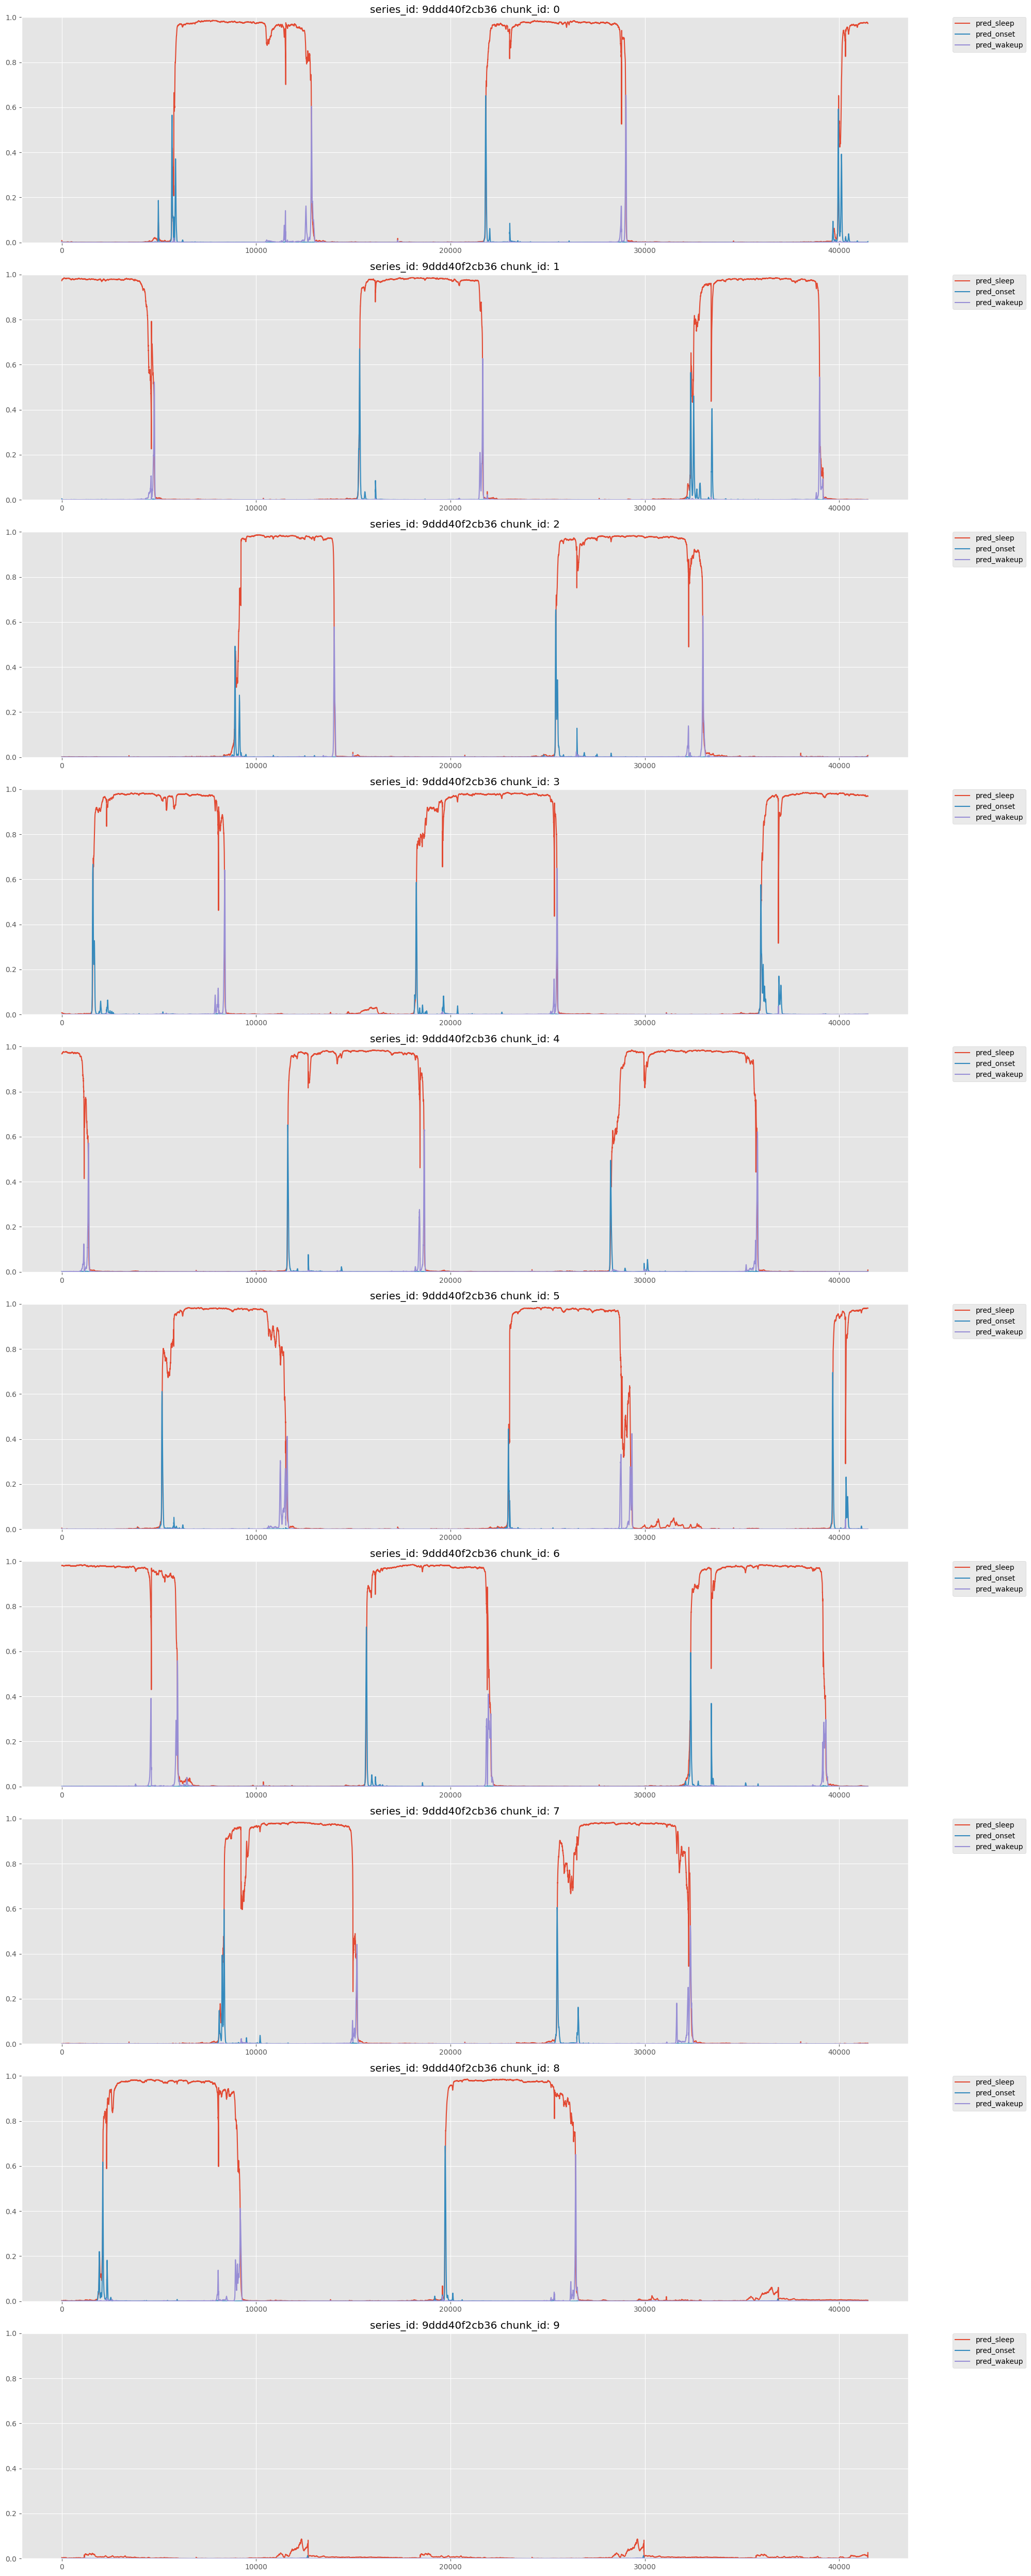

In [15]:
plot_random_sample(keys, preds, labels, num_chunks=10)